In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import time

import torch
import torch.nn as nn
import torchvision.transforms as tvtf
import torchvision.utils as tvutils

import gan_model_definitions

In [2]:
image_size = 128
image_content_types = ['Leaf', 'Flower', 'Entire', 'Fruit', 'Stem']

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        super(ImageDataset, self).__init__()
        self.image_paths = df.jpg.tolist()
        self.image_content = np.eye(len(image_content_types))[df.content.map(image_content_types.index)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = PIL.Image.open(self.image_paths[idx])        
        image_tensor = tvtf.Compose([
            tvtf.Resize(image_size),
            tvtf.CenterCrop(image_size),
            tvtf.ToTensor(),
            tvtf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])(image)
        
        image_content_tensor = torch.FloatTensor(self.image_content[idx])

        return image_tensor, image_content_tensor

In [3]:
device = torch.device("cuda:0")
batch_size = 64
dataset = ImageDataset(pd.read_json("data/data.json"))
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True, num_workers = 2)

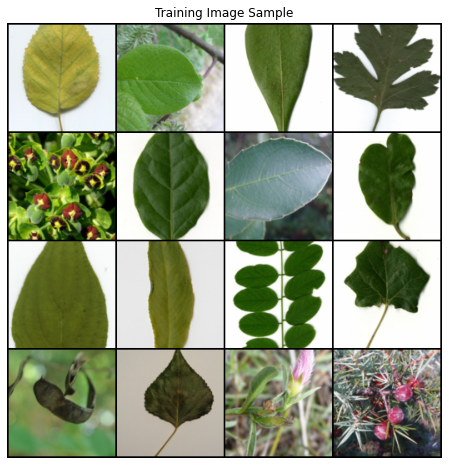

In [4]:
sample_batch = next(iter(dataloader))
plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Training Image Sample")
plt.imshow(np.transpose(
    tvutils.make_grid(sample_batch[0][:16], padding = 2, normalize = True, nrow = 4),
    (1, 2, 0)
))

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
# Create the generator
netG = gan_model_definitions.Generator(image_content_types).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

print(netG)

Generator(
  (image_conv): Sequential(
    (0): ParametrizedConvTranspose2d(
      200, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ParametrizedConvTranspose2d(
      1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ParametrizedConvTranspose2d(
      512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )


In [7]:
netD = gan_model_definitions.Discriminator(image_content_types).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

print(netD)

Discriminator(
  (image_conv): Sequential(
    (0): ParametrizedConv2d(
      3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): ParametrizedConv2d(
      64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ParametrizedConv2d(
      128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Le

In [8]:
def create_noise():
    noise = torch.randn(batch_size, gan_model_definitions.nz - len(image_content_types), 1, 1, device = device)
    random_content_types = np.eye(len(image_content_types))[
        np.random.choice(range(len(image_content_types)), batch_size)
    ]
    return torch.cat((
        noise,
        torch.tensor(random_content_types).view((batch_size, len(image_content_types), 1, 1)).to(device)
    ), dim = 1).float()
    

In [9]:
# Learning rate for G optimizer
g_lr = 0.0001

# Learning rate for D optimizer
d_lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.7

criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = create_noise()

# Establish convention for real and fake labels during training
# Use 0.9 instead of 1.0 (label smoothing)
real_label = 0.9
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr = g_lr, betas = (beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr = d_lr, betas = (beta1, 0.999))

In [10]:
num_epochs = 200

# Training Loop

# Lists to keep track of progress
img_list = []
class_list = []
G_losses = []
D_losses = []
iters = 0

start = time.time()
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (image, image_class) in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_image = image.to(device)
        real_class = image_class.to(device)
        b_size = real_image.size(0)
        label = torch.full((b_size,), real_label, dtype = torch.float, device = device)
        # Forward pass real batch through D
        output = netD(real_image, real_class).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = create_noise()
        # Generate fake image batch with G
        fake_image, fake_class = netG(noise)
        label = torch.full((fake_image.size(0),), fake_label, dtype = torch.float, device = device)
        # Classify all fake batch with D
        output = netD(fake_image.detach(), fake_class.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake_image, fake_class).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            elapsed = time.time() - start
            elapsed_seconds = elapsed % 60
            elapsed_minutes = (elapsed // 60) % 60
            elapsed_hours = elapsed // 3600
            print('[%3d/%3d][%3d/%3d]  Loss_D: %.3f  Loss_G: %.3f  D(x): %.3f  D(G(z)): %.3f/%.3f  [Elapsed: %02d:%02d:%02d]'
                  % (epoch + 1, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2,
                     elapsed_hours, elapsed_minutes, elapsed_seconds))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake_image, fake_class = netG(fixed_noise)
            img_list.extend(fake_image.detach().cpu())
            class_list.extend(fake_class.detach().cpu().argmax(1))

        iters += 1

[  1/200][  0/190]  Loss_D: 1.386  Loss_G: 1.321  D(x): 0.532  D(G(z)): 0.523/0.238  [Elapsed: 00:00:01]
[  1/200][ 50/190]  Loss_D: 0.550  Loss_G: 1.513  D(x): 0.857  D(G(z)): 0.193/0.191  [Elapsed: 00:00:22]
[  1/200][100/190]  Loss_D: 0.534  Loss_G: 1.728  D(x): 0.795  D(G(z)): 0.153/0.149  [Elapsed: 00:00:44]
[  1/200][150/190]  Loss_D: 0.489  Loss_G: 1.877  D(x): 0.820  D(G(z)): 0.126/0.126  [Elapsed: 00:01:04]
[  2/200][  0/190]  Loss_D: 0.453  Loss_G: 1.950  D(x): 0.872  D(G(z)): 0.117/0.116  [Elapsed: 00:01:20]
[  2/200][ 50/190]  Loss_D: 0.441  Loss_G: 2.028  D(x): 0.874  D(G(z)): 0.107/0.106  [Elapsed: 00:01:42]
[  2/200][100/190]  Loss_D: 1.086  Loss_G: 1.393  D(x): 0.521  D(G(z)): 0.333/0.223  [Elapsed: 00:02:02]
[  2/200][150/190]  Loss_D: 0.760  Loss_G: 1.604  D(x): 0.583  D(G(z)): 0.149/0.175  [Elapsed: 00:02:22]
[  3/200][  0/190]  Loss_D: 0.732  Loss_G: 1.963  D(x): 0.758  D(G(z)): 0.276/0.115  [Elapsed: 00:02:39]
[  3/200][ 50/190]  Loss_D: 0.712  Loss_G: 1.803  D(x):

[ 20/200][150/190]  Loss_D: 0.434  Loss_G: 3.181  D(x): 0.852  D(G(z)): 0.080/0.032  [Elapsed: 00:26:06]
[ 21/200][  0/190]  Loss_D: 0.411  Loss_G: 3.957  D(x): 0.829  D(G(z)): 0.046/0.013  [Elapsed: 00:26:23]
[ 21/200][ 50/190]  Loss_D: 0.420  Loss_G: 3.759  D(x): 0.809  D(G(z)): 0.039/0.016  [Elapsed: 00:26:44]
[ 21/200][100/190]  Loss_D: 0.526  Loss_G: 3.416  D(x): 0.887  D(G(z)): 0.169/0.024  [Elapsed: 00:27:05]
[ 21/200][150/190]  Loss_D: 0.485  Loss_G: 4.051  D(x): 0.720  D(G(z)): 0.015/0.012  [Elapsed: 00:27:25]
[ 22/200][  0/190]  Loss_D: 1.211  Loss_G: 3.657  D(x): 0.765  D(G(z)): 0.508/0.018  [Elapsed: 00:27:42]
[ 22/200][ 50/190]  Loss_D: 0.601  Loss_G: 3.653  D(x): 0.923  D(G(z)): 0.217/0.019  [Elapsed: 00:28:03]
[ 22/200][100/190]  Loss_D: 0.390  Loss_G: 3.721  D(x): 0.847  D(G(z)): 0.035/0.018  [Elapsed: 00:28:24]
[ 22/200][150/190]  Loss_D: 0.828  Loss_G: 2.333  D(x): 0.656  D(G(z)): 0.245/0.090  [Elapsed: 00:28:45]
[ 23/200][  0/190]  Loss_D: 0.558  Loss_G: 3.220  D(x):

[ 40/200][100/190]  Loss_D: 0.395  Loss_G: 3.877  D(x): 0.821  D(G(z)): 0.030/0.016  [Elapsed: 00:52:16]
[ 40/200][150/190]  Loss_D: 0.390  Loss_G: 3.771  D(x): 0.891  D(G(z)): 0.053/0.019  [Elapsed: 00:52:37]
[ 41/200][  0/190]  Loss_D: 0.599  Loss_G: 3.114  D(x): 0.910  D(G(z)): 0.217/0.038  [Elapsed: 00:52:54]
[ 41/200][ 50/190]  Loss_D: 0.407  Loss_G: 3.913  D(x): 0.811  D(G(z)): 0.032/0.016  [Elapsed: 00:53:15]
[ 41/200][100/190]  Loss_D: 0.409  Loss_G: 2.987  D(x): 0.837  D(G(z)): 0.049/0.048  [Elapsed: 00:53:36]
[ 41/200][150/190]  Loss_D: 0.369  Loss_G: 3.457  D(x): 0.865  D(G(z)): 0.028/0.029  [Elapsed: 00:53:56]
[ 42/200][  0/190]  Loss_D: 0.439  Loss_G: 3.821  D(x): 0.761  D(G(z)): 0.023/0.016  [Elapsed: 00:54:13]
[ 42/200][ 50/190]  Loss_D: 0.542  Loss_G: 2.435  D(x): 0.780  D(G(z)): 0.127/0.086  [Elapsed: 00:54:34]
[ 42/200][100/190]  Loss_D: 0.460  Loss_G: 2.511  D(x): 0.855  D(G(z)): 0.103/0.071  [Elapsed: 00:54:55]
[ 42/200][150/190]  Loss_D: 0.593  Loss_G: 2.764  D(x):

[ 60/200][ 50/190]  Loss_D: 0.532  Loss_G: 2.131  D(x): 0.678  D(G(z)): 0.038/0.121  [Elapsed: 01:18:26]
[ 60/200][100/190]  Loss_D: 0.407  Loss_G: 3.105  D(x): 0.812  D(G(z)): 0.031/0.042  [Elapsed: 01:18:46]
[ 60/200][150/190]  Loss_D: 0.514  Loss_G: 2.882  D(x): 0.713  D(G(z)): 0.045/0.055  [Elapsed: 01:19:07]
[ 61/200][  0/190]  Loss_D: 0.430  Loss_G: 3.830  D(x): 0.777  D(G(z)): 0.031/0.017  [Elapsed: 01:19:24]
[ 61/200][ 50/190]  Loss_D: 0.385  Loss_G: 3.735  D(x): 0.920  D(G(z)): 0.046/0.019  [Elapsed: 01:19:45]
[ 61/200][100/190]  Loss_D: 0.431  Loss_G: 3.503  D(x): 0.869  D(G(z)): 0.077/0.025  [Elapsed: 01:20:06]
[ 61/200][150/190]  Loss_D: 0.394  Loss_G: 3.270  D(x): 0.892  D(G(z)): 0.054/0.033  [Elapsed: 01:20:27]
[ 62/200][  0/190]  Loss_D: 0.364  Loss_G: 4.018  D(x): 0.910  D(G(z)): 0.028/0.014  [Elapsed: 01:20:44]
[ 62/200][ 50/190]  Loss_D: 0.424  Loss_G: 3.608  D(x): 0.867  D(G(z)): 0.076/0.024  [Elapsed: 01:21:05]
[ 62/200][100/190]  Loss_D: 0.883  Loss_G: 2.795  D(x):

[ 80/200][  0/190]  Loss_D: 0.364  Loss_G: 4.462  D(x): 0.921  D(G(z)): 0.024/0.011  [Elapsed: 01:44:39]
[ 80/200][ 50/190]  Loss_D: 0.502  Loss_G: 3.058  D(x): 0.851  D(G(z)): 0.133/0.043  [Elapsed: 01:45:00]
[ 80/200][100/190]  Loss_D: 0.497  Loss_G: 3.689  D(x): 0.935  D(G(z)): 0.136/0.022  [Elapsed: 01:45:20]
[ 80/200][150/190]  Loss_D: 0.373  Loss_G: 3.468  D(x): 0.881  D(G(z)): 0.029/0.028  [Elapsed: 01:45:41]
[ 81/200][  0/190]  Loss_D: 0.398  Loss_G: 3.658  D(x): 0.883  D(G(z)): 0.054/0.023  [Elapsed: 01:45:59]
[ 81/200][ 50/190]  Loss_D: 0.403  Loss_G: 3.583  D(x): 0.809  D(G(z)): 0.019/0.024  [Elapsed: 01:46:19]
[ 81/200][100/190]  Loss_D: 0.573  Loss_G: 3.403  D(x): 0.858  D(G(z)): 0.187/0.028  [Elapsed: 01:46:40]
[ 81/200][150/190]  Loss_D: 0.494  Loss_G: 3.120  D(x): 0.974  D(G(z)): 0.086/0.043  [Elapsed: 01:47:01]
[ 82/200][  0/190]  Loss_D: 0.519  Loss_G: 3.070  D(x): 0.961  D(G(z)): 0.134/0.045  [Elapsed: 01:47:18]
[ 82/200][ 50/190]  Loss_D: 0.422  Loss_G: 2.162  D(x):

[ 99/200][150/190]  Loss_D: 0.364  Loss_G: 4.020  D(x): 0.905  D(G(z)): 0.023/0.015  [Elapsed: 02:10:56]
[100/200][  0/190]  Loss_D: 0.440  Loss_G: 3.326  D(x): 0.955  D(G(z)): 0.075/0.033  [Elapsed: 02:11:13]
[100/200][ 50/190]  Loss_D: 0.380  Loss_G: 3.616  D(x): 0.922  D(G(z)): 0.038/0.025  [Elapsed: 02:11:34]
[100/200][100/190]  Loss_D: 0.349  Loss_G: 5.047  D(x): 0.906  D(G(z)): 0.013/0.005  [Elapsed: 02:11:55]
[100/200][150/190]  Loss_D: 0.663  Loss_G: 3.157  D(x): 0.962  D(G(z)): 0.238/0.037  [Elapsed: 02:12:16]
[101/200][  0/190]  Loss_D: 0.390  Loss_G: 3.184  D(x): 0.939  D(G(z)): 0.041/0.041  [Elapsed: 02:12:33]
[101/200][ 50/190]  Loss_D: 0.467  Loss_G: 2.866  D(x): 0.887  D(G(z)): 0.117/0.054  [Elapsed: 02:12:54]
[101/200][100/190]  Loss_D: 0.628  Loss_G: 2.042  D(x): 0.641  D(G(z)): 0.079/0.142  [Elapsed: 02:13:14]
[101/200][150/190]  Loss_D: 0.388  Loss_G: 4.342  D(x): 0.900  D(G(z)): 0.046/0.011  [Elapsed: 02:13:35]
[102/200][  0/190]  Loss_D: 0.445  Loss_G: 2.977  D(x):

[119/200][100/190]  Loss_D: 0.444  Loss_G: 3.517  D(x): 0.768  D(G(z)): 0.034/0.027  [Elapsed: 02:37:32]
[119/200][150/190]  Loss_D: 0.389  Loss_G: 3.413  D(x): 0.922  D(G(z)): 0.046/0.032  [Elapsed: 02:37:53]
[120/200][  0/190]  Loss_D: 0.423  Loss_G: 3.388  D(x): 0.920  D(G(z)): 0.080/0.029  [Elapsed: 02:38:10]
[120/200][ 50/190]  Loss_D: 0.440  Loss_G: 3.725  D(x): 0.746  D(G(z)): 0.017/0.023  [Elapsed: 02:38:31]
[120/200][100/190]  Loss_D: 0.400  Loss_G: 2.406  D(x): 0.913  D(G(z)): 0.057/0.095  [Elapsed: 02:38:52]
[120/200][150/190]  Loss_D: 0.468  Loss_G: 3.590  D(x): 0.877  D(G(z)): 0.103/0.025  [Elapsed: 02:39:13]
[121/200][  0/190]  Loss_D: 0.572  Loss_G: 2.563  D(x): 0.966  D(G(z)): 0.161/0.082  [Elapsed: 02:39:30]
[121/200][ 50/190]  Loss_D: 0.497  Loss_G: 3.043  D(x): 0.705  D(G(z)): 0.033/0.048  [Elapsed: 02:39:51]
[121/200][100/190]  Loss_D: 0.410  Loss_G: 3.880  D(x): 0.785  D(G(z)): 0.020/0.018  [Elapsed: 02:40:12]
[121/200][150/190]  Loss_D: 0.540  Loss_G: 3.190  D(x):

[139/200][ 50/190]  Loss_D: 0.499  Loss_G: 3.118  D(x): 0.974  D(G(z)): 0.094/0.045  [Elapsed: 03:03:44]
[139/200][100/190]  Loss_D: 0.413  Loss_G: 3.830  D(x): 0.874  D(G(z)): 0.061/0.019  [Elapsed: 03:04:05]
[139/200][150/190]  Loss_D: 0.466  Loss_G: 1.890  D(x): 0.924  D(G(z)): 0.116/0.157  [Elapsed: 03:04:26]
[140/200][  0/190]  Loss_D: 0.372  Loss_G: 3.751  D(x): 0.899  D(G(z)): 0.036/0.023  [Elapsed: 03:04:43]
[140/200][ 50/190]  Loss_D: 0.358  Loss_G: 4.688  D(x): 0.936  D(G(z)): 0.017/0.008  [Elapsed: 03:05:04]
[140/200][100/190]  Loss_D: 0.405  Loss_G: 3.579  D(x): 0.854  D(G(z)): 0.056/0.025  [Elapsed: 03:05:25]
[140/200][150/190]  Loss_D: 0.379  Loss_G: 3.947  D(x): 0.934  D(G(z)): 0.033/0.016  [Elapsed: 03:05:46]
[141/200][  0/190]  Loss_D: 0.341  Loss_G: 5.699  D(x): 0.907  D(G(z)): 0.004/0.002  [Elapsed: 03:06:03]
[141/200][ 50/190]  Loss_D: 0.373  Loss_G: 4.076  D(x): 0.918  D(G(z)): 0.032/0.014  [Elapsed: 03:06:24]
[141/200][100/190]  Loss_D: 0.363  Loss_G: 4.011  D(x):

[159/200][  0/190]  Loss_D: 0.377  Loss_G: 3.067  D(x): 0.863  D(G(z)): 0.027/0.047  [Elapsed: 03:29:55]
[159/200][ 50/190]  Loss_D: 0.467  Loss_G: 3.060  D(x): 0.727  D(G(z)): 0.016/0.049  [Elapsed: 03:30:16]
[159/200][100/190]  Loss_D: 0.440  Loss_G: 3.416  D(x): 0.855  D(G(z)): 0.085/0.029  [Elapsed: 03:30:37]
[159/200][150/190]  Loss_D: 0.354  Loss_G: 4.534  D(x): 0.881  D(G(z)): 0.013/0.012  [Elapsed: 03:30:58]
[160/200][  0/190]  Loss_D: 0.353  Loss_G: 4.550  D(x): 0.898  D(G(z)): 0.014/0.008  [Elapsed: 03:31:15]
[160/200][ 50/190]  Loss_D: 0.398  Loss_G: 4.339  D(x): 0.909  D(G(z)): 0.058/0.012  [Elapsed: 03:31:36]
[160/200][100/190]  Loss_D: 0.354  Loss_G: 4.936  D(x): 0.854  D(G(z)): 0.007/0.006  [Elapsed: 03:31:57]
[160/200][150/190]  Loss_D: 0.738  Loss_G: 2.645  D(x): 0.968  D(G(z)): 0.275/0.079  [Elapsed: 03:32:17]
[161/200][  0/190]  Loss_D: 0.355  Loss_G: 5.226  D(x): 0.851  D(G(z)): 0.007/0.005  [Elapsed: 03:32:35]
[161/200][ 50/190]  Loss_D: 0.473  Loss_G: 3.540  D(x):

[178/200][150/190]  Loss_D: 0.415  Loss_G: 4.753  D(x): 0.915  D(G(z)): 0.070/0.008  [Elapsed: 03:56:13]
[179/200][  0/190]  Loss_D: 0.415  Loss_G: 3.831  D(x): 0.867  D(G(z)): 0.060/0.020  [Elapsed: 03:56:30]
[179/200][ 50/190]  Loss_D: 0.399  Loss_G: 4.043  D(x): 0.883  D(G(z)): 0.056/0.016  [Elapsed: 03:56:51]
[179/200][100/190]  Loss_D: 0.396  Loss_G: 4.811  D(x): 0.794  D(G(z)): 0.007/0.008  [Elapsed: 03:57:12]
[179/200][150/190]  Loss_D: 0.390  Loss_G: 3.803  D(x): 0.923  D(G(z)): 0.047/0.029  [Elapsed: 03:57:32]
[180/200][  0/190]  Loss_D: 0.460  Loss_G: 3.529  D(x): 0.953  D(G(z)): 0.091/0.031  [Elapsed: 03:57:50]
[180/200][ 50/190]  Loss_D: 0.345  Loss_G: 5.263  D(x): 0.876  D(G(z)): 0.008/0.004  [Elapsed: 03:58:10]
[180/200][100/190]  Loss_D: 0.427  Loss_G: 3.980  D(x): 0.898  D(G(z)): 0.079/0.021  [Elapsed: 03:58:31]
[180/200][150/190]  Loss_D: 0.364  Loss_G: 4.702  D(x): 0.898  D(G(z)): 0.025/0.007  [Elapsed: 03:58:52]
[181/200][  0/190]  Loss_D: 0.343  Loss_G: 5.457  D(x):

[198/200][100/190]  Loss_D: 0.403  Loss_G: 5.167  D(x): 0.781  D(G(z)): 0.006/0.006  [Elapsed: 04:22:25]
[198/200][150/190]  Loss_D: 0.397  Loss_G: 3.616  D(x): 0.825  D(G(z)): 0.035/0.027  [Elapsed: 04:22:46]
[199/200][  0/190]  Loss_D: 0.369  Loss_G: 3.658  D(x): 0.921  D(G(z)): 0.027/0.034  [Elapsed: 04:23:03]
[199/200][ 50/190]  Loss_D: 0.955  Loss_G: 2.203  D(x): 0.413  D(G(z)): 0.012/0.133  [Elapsed: 04:23:24]
[199/200][100/190]  Loss_D: 0.374  Loss_G: 5.083  D(x): 0.816  D(G(z)): 0.006/0.006  [Elapsed: 04:23:44]
[199/200][150/190]  Loss_D: 0.365  Loss_G: 4.610  D(x): 0.937  D(G(z)): 0.017/0.010  [Elapsed: 04:24:05]
[200/200][  0/190]  Loss_D: 0.391  Loss_G: 3.648  D(x): 0.911  D(G(z)): 0.048/0.028  [Elapsed: 04:24:22]
[200/200][ 50/190]  Loss_D: 0.417  Loss_G: 5.442  D(x): 0.754  D(G(z)): 0.002/0.004  [Elapsed: 04:24:43]
[200/200][100/190]  Loss_D: 0.434  Loss_G: 3.903  D(x): 0.771  D(G(z)): 0.028/0.020  [Elapsed: 04:25:04]
[200/200][150/190]  Loss_D: 0.345  Loss_G: 4.666  D(x):

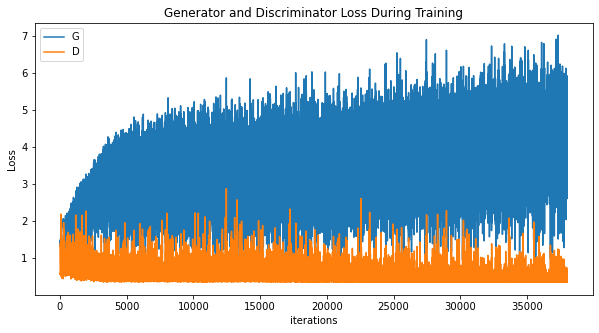

In [11]:
plt.figure(figsize = (10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

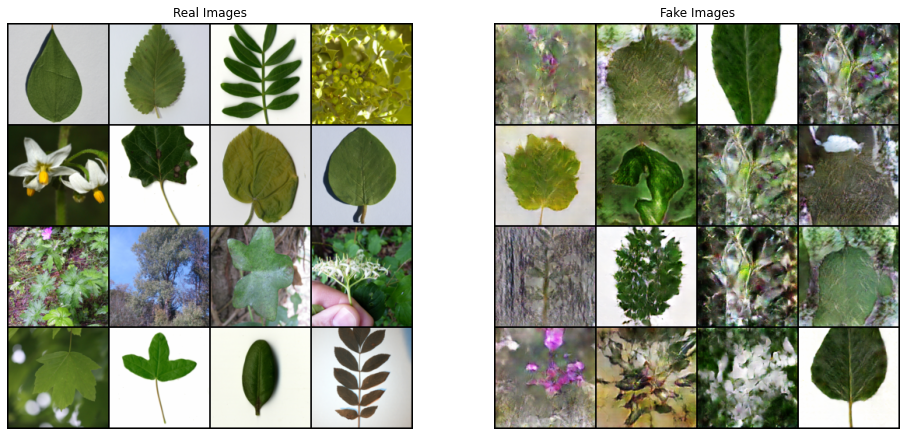

In [12]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize = (16, 16))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(
    tvutils.make_grid(real_batch[0][:16], normalize = True, nrow = 4),
    (1, 2, 0))
)

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(
    tvutils.make_grid(img_list[-16:], padding = 2, normalize = True, nrow = 4),
    (1, 2, 0)
))

plt.show()

In [13]:
torch.save(netG.state_dict(), "models/128x128_tmp.pkl")